# Assignment 1

In the first assignment, you will implement some of the algorithms you have learnt in the first two weeks of lectures: n-gram language models, and syntactic parsing using the CYK algorithm.

# Setup

For this and other assignments, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then upload the file to Gradescope.


__Paste your notebook link in the box below.__ _(0 points)_

https://colab.research.google.com/drive/1cnDgl7hqNgmGANwnHajak3-7zauo63gm?usp=sharing

In [1]:
# Downloads required packages and files
required_files = "https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip"
! wget $required_files && unzip -o required_files.zip
! pip install -r requirements.txt

--2025-09-17 00:58:51--  https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip [following]
--2025-09-17 00:58:51--  https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11474 (11K) [application/zip]
Saving to: ‘required_files.zip’

required_files.zip  100%[=================

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

In [3]:
import random
import math
import re
import os
import urllib
import json
from typing import *
from collections import Counter, defaultdict

import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer, sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Part 1: N-gram Language Models

For the first part of this assignment, you will implement a trigram language model and train it on a small corpus. You will then implement a scoring function to compute the perplexity of the model on a held-out test set. Finally, you will implement some methods to deal with sparsity (zero count) issues in your model.

To ease you into the implementation, we will provide some boilerplate code that you would need to fill in depending upon the functionalities the code is supposed to perform. For the first few sections below, we will use the complete text from Leo Tolstoy's "War and Peace," which is freely available from [Project Gutenberg](https://www.gutenberg.org/). Run the following code block to download the text.

In [4]:
def download_data():
    def _download(url: str, filename: str) -> str:
        txt = urllib.request.urlopen(url)
        with open(filename, 'w') as f:
            f.write(txt.read().decode('utf-8'))

    _download('https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt', 'warpeace_input.txt')
    _download('http://www.gutenberg.org/files/1399/1399-0.txt', '1399-0.txt')

download_data()

The complete text downloaded above contains punctuations which are not important for our purposes. So we will perform a basic text preprocessing using the [NLTK toolkit](https://www.nltk.org/). We will store the processed text into a list of strings, where each string will contain words without any punctuations. We will also convert all words to lower case.

In [5]:
# Loading the text
try:
    with open('warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')

In [6]:
sentences = sent_tokenize(corpus_raw)

corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    corpus.append([token.lower() for token in tokens])

print("Corpus has {} sentences".format(len(corpus)))

Corpus has 32040 sentences


### Warm-up: n-gram counts from a corpus

Let's start with implementing a simple function for obtaining n-grams and their counts from a string. Complete the following function. _(5 points)_

__Note 1:__ Use the special token `~` for both beginning of sentence (BOS) and end of sentence (EOS) tokens. For example, the sentence "Mary has a little lamb" has the bigrams "_~ Mary_", "_Mary has_", "_has a_", "_a little_", "_little lamb_", and "_lamb ~_".

__Note 2:__ You don't need to do any further text processing beyond what has already been done before.

__Note 3:__ For the usage of `collections.Counter`, you can refer to [its python doc](https://docs.python.org/3/library/collections.html#collections.Counter).

In [7]:
def generate_ngrams(text: List[str], n: int) -> Counter:
    """Generates all n-grams (i.e. n-1 context words) for the given text.

    Parameters
    ----------
    text : List[str]
        Input text (list of strings) after tokenization.
    n : int
        n-gram parameter (must be greater than or equal to 1).

    Returns
    -------
    ngrams : Counter
        Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]),
        where `ngram` is a n-gram tuple and `count` is an integer count.
        e.g. ('Mary','has') and value as count of the n-gram in the text.
    """
    assert (isinstance(n, int) and n > 0)

    ngrams = Counter()

    # TODO: Your code here.
    ...
    ap_text = ['~'] * (n - 1) + text + ['~'] * (n - 1)
    for i in range(len(ap_text) - n + 1):
        ngrams[tuple(ap_text[i:i+n])] += 1

    return ngrams


def generate_ngrams_sentences(text: List[List[str]], n: int) -> Counter:
    """Generates n-grams for each sentence and aggregates them."""
    all_ngrams = Counter()
    for sentence in text:
        all_ngrams.update(generate_ngrams(sentence, n))
    return all_ngrams

In [8]:
# Test your implementation on some sentences from the corpus we downloaded above
# and verify if it works correctly.
text = corpus[:10]
print(text)

ngrams = generate_ngrams_sentences(text, 3)
print(ngrams)

[['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes'], ['but', 'i', 'warn', 'you', 'if', 'you', 'don', 't', 'tell', 'me', 'that', 'this', 'means', 'war', 'if', 'you', 'still', 'try', 'to', 'defend', 'the', 'infamies', 'and', 'horrors', 'perpetrated', 'by', 'that', 'antichrist', 'i', 'really', 'believe', 'he', 'is', 'antichrist', 'i', 'will', 'have', 'nothing', 'more', 'to', 'do', 'with', 'you', 'and', 'you', 'are', 'no', 'longer', 'my', 'friend', 'no', 'longer', 'my', 'faithful', 'slave', 'as', 'you', 'call', 'yourself'], ['but', 'how', 'do', 'you', 'do'], ['i', 'see', 'i', 'have', 'frightened', 'you', 'sit', 'down', 'and', 'tell', 'me', 'all', 'the', 'news'], ['it', 'was', 'in', 'july', '1805', 'and', 'the', 'speaker', 'was', 'the', 'well', 'known', 'anna', 'pavlovna', 'scherer', 'maid', 'of', 'honor', 'and', 'favorite', 'of', 'the', 'empress', 'marya', 'fedorovna'], ['with', 'these', 'words', 'she', 'greeted', 'princ

In [9]:
grader.check("warmup-ngram")

warmup-ngram results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Plot a histogram of counts vs. number of unigrams with that count (you can choose a subset of the corpus, say 500 sentences). Repeat for bigrams and trigrams. They should be all placed into a single plot. _(3 points)_

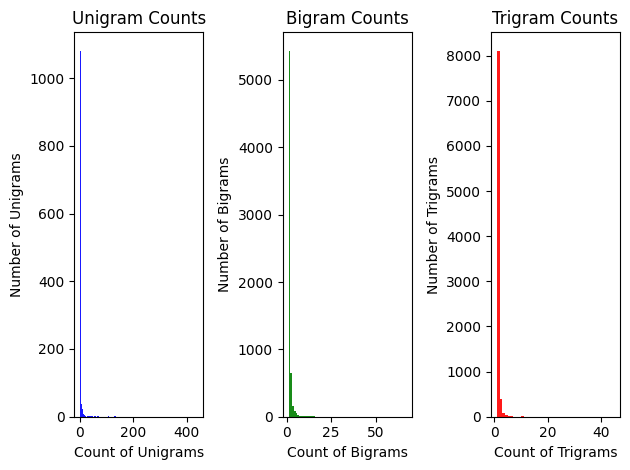

In [10]:
fig, axs = plt.subplots(1, 3, tight_layout=True)

# Picks a subset of the corpus
text = corpus[:500]

# Unigram counts
unigrams = Counter()
unigrams.update(generate_ngrams_sentences(text, 1))
unigram_counts = list(unigrams.values())
axs[0].hist(unigram_counts, bins=range(1, max(unigram_counts) + 1), alpha=0.9, color='blue')
axs[0].set_title('Unigram Counts')
axs[0].set_xlabel('Count of Unigrams')
axs[0].set_ylabel('Number of Unigrams')

# Bigram counts
bigrams = Counter()
bigrams.update(generate_ngrams_sentences(text, 2))
bigram_counts = list(bigrams.values())
axs[1].hist(bigram_counts, bins=range(1, max(bigram_counts) + 1), alpha=0.9, color='green')
axs[1].set_title('Bigram Counts')
axs[1].set_xlabel('Count of Bigrams')
axs[1].set_ylabel('Number of Bigrams')

# Trigram counts
trigrams = Counter()
trigrams.update(generate_ngrams_sentences(text, 3))
trigram_counts = list(trigrams.values())
axs[2].hist(trigram_counts, bins=range(1, max(trigram_counts) + 1), alpha=0.9, color='red')
axs[2].set_title('Trigram Counts')
axs[2].set_xlabel('Count of Trigrams')
axs[2].set_ylabel('Number of Trigrams')

plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ What observation can you make from the plots? _(2 points)_

__Answer:__

The frequency of n-grams reduces as we go from unigrams to trigrams. The distribution spreads out with many of them having low frequencies. This could mean that individual words can be found more than longer sequences.

<!-- END QUESTION -->

### Implementing an n-gram language model

Next, you will implement a class for an trigram (n=3) language model. This will be a barebones trigram LM, i.e., no smoothing or OOV handling is required. Complete
the functions in the following `NgramLM` class. _(20 points)_

Note that the class itself is
for a general n-gram LM, but we will instantiate it with n=3.

_Type your answer here, replacing this text._

In [11]:
class NgramLM(object):
    """A basic n-gram language model without any smoothing."""

    def __init__(self, n: int):
        assert (isinstance(n, int) and n > 0)

        self.n: int = n
        self.vocab: Set[str] = set()  # A set of all words appearing in the corpus.
        self.ngrams = Counter()  # count(ABC) - Dict[Tuple, int]
        self.ngram_contexts = Counter()  # count(AB) - Dict[Tuple, int]
        self.contexts = defaultdict(set)  # {AB: {C1,C2,C2}} - Dict[Tuple, Set[str]]

    def generate_ngrams(self, text: List[str]) -> Counter:
        """Generates all n-grams (i.e. n-1 context words) for the given text.
        In this method, we assume n is defined at the class initialization,
        so you should use `self.n`.

        Parameters
        ----------
        text : List[str]
            Input text (list of strings) after tokenization.

        Returns
        -------
        ngrams : Counter
            Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]),
            where `ngram` is a n-gram tuple and `count` is an integer count.
            e.g. ('Mary','has') and value as count of the n-gram in the text.
        """
        return generate_ngrams(text, self.n)

    def generate_ngrams_sentences(self, text: List[List[str]]) -> Counter:
        """Generates n-grams for each sentence and aggregates them."""
        return generate_ngrams_sentences(text, self.n)

    def update(self, text: List[str]):
        """Updates the model n-grams based on the given text input.

        Parameters
        ----------
        text : List[str]
        """
        # TODO: Your code here
        ngrams = self.generate_ngrams(text)
        for ngram,count in ngrams.items():
          self.ngrams[ngram] += count
          context = ngram[:-1]
          word = ngram[-1]
          self.ngram_contexts[context] += count
          self.contexts[context].add(word)
          self.vocab.update(ngram)

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        if context not in self.ngram_contexts or (context + (word,)) not in self.ngrams:
              return 0.0
        return self.ngrams[context + (word,)] / self.ngram_contexts[context]

    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        if context not in self.contexts:
              return []
        return list(self.contexts[context])

    def random_word(self, context: Tuple[str]) -> str:
        """Generates a random word based on the given context.

        Note:
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        word : str
            One randomly drawn word from the distribution defined given the context.
        """
        assert context in self.contexts, f'Encountered unseen context={context}.'

        potential_random_word = self.next_word_candidates(context)
        occur_chance = [self.word_prob(context,i) for i in potential_random_word]
        return random.choices(potential_random_word, weights=occur_chance)[0]

    def random_text(self, length: int) -> List[str]:
        """Generates random text of the specified word length excluding "~" (BOS).

        Note:
        - The final word of the generated text *can* be "~" (EOS), but it is not necessary.
        - The generation should always start with "~" (BOS).
        - Only the number of starting "~" (BOS) is excluded from the generation, any
        ending "~" (EOS) is still counted to the `length`. It means that you should
        draw a number of `length` samples.

        Note:
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.

        Parameters
        ----------
        length : int
            The designated length to generate.

        """
        if length == 0:
          return []
        context = ('~',) * (self.n - 1)
        final_text = []
        for _ in range(length):
          next_word = self.random_word(context)
          final_text.append(next_word)
          context = (*context[1:], next_word)

        return final_text


In [12]:
# Training block for a trigram language model
trigramlm = NgramLM(3)
for sentence in corpus:
    trigramlm.update(sentence)

In [13]:
grader.check("ngramlm-impl")

ngramlm-impl results: All test cases passed!

__Question:__ What is the size of the training data (number of tokens)? _(1 point)_

In [14]:
training_corpus_size = sum(len(tokens) for tokens in corpus)
training_corpus_size

571824

__Question:__ What is the size of the vocabulary? _(1 point)_

In [15]:
trigramlm_vocab_size = len(trigramlm.vocab)
trigramlm_vocab_size

17511

<!-- BEGIN QUESTION -->

__Question:__ What is the optimal time complexity of computing ngrams? How long does the training take? _(2 points)_

*Note*: please use big-O notation to show the time complexity and explain variables involved accordingly.

__Answer:__

Time Complexity depends on number of tokens t and length of the n-gram n. Total time will be (t - n + 1) to get all the n-grams as we slide over all the tokens in the dataset and portion off size n. So, the time complexity is O(t) i.e., linear time. Training will also take O(t) as updating the counts in hash map takes constant time.

In [16]:
# TODO: put the training time (in ms) of a trigram LM below.
import time
start = time.time()
trigramlm = NgramLM(3)
for sentence in corpus:
    trigramlm.update(sentence)
end = time.time()
trigram_training_time = end - start
trigram_training_time

3.5032804012298584

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ How would the training time scale if you have a corpus containing 1 billion tokens? Is this training time reasonable? If not, can you think of ways to improve it? _(2 points)_

__Answer:__

The training time would scale linearly as time complexity is linear in nature. 1 billion tokens should be feasible but there could be memory utilization issues due to large number of tokens. We can use parallel processing (use multiple processors) to improve the performance. We can also use sampling to reduce the number of tokens.

<!-- END QUESTION -->

#### Predicting/generating text using the trained LM

One of the applications of an LM is to automatically predict the next word given a context (such as in Smart Keyboards), or to generate a piece of text of a given length. Use the `random_word` and `random_text` functions you implemented earlier to answer the questions below. For full credit, you need to show how you arrived at the answer.

__Question:__ Please implement the function that computes an empirical distribution for the next word prediction conditioning on a context. Consider the context "by her". You can generate a random word for a large number of times, say 1000, using this context and count how many times each word are generated to calculate its empirical probability accordingly. _(3 points)_

In [17]:
def compute_empirical_distribution(model: NgramLM, context: Tuple[str], num_samples: int) -> Dict[str, float]:
    """Computes an empirical distribution for the next word conditioning on the given context.

    Parameters
    ----------
    model : NgramLM
        A trained Ngram Language Model.
    context : Tuple[str]
        The context used to predict a next word.
    num_samples : int
        The number of samples to be drawn to compute the empirical distribution.

    Returns
    -------
    emp_distr : Dict[str, float]
        An empirical distribution for the next word

    """
    wfreq = defaultdict(int)

    for i in range(num_samples):
        word = model.random_word(context)
        wfreq[word] += 1

    total_words = sum(wfreq.values())
    emp_distr = {word: count / total_words for word, count in wfreq.items()}

    return emp_distr

In [18]:
compute_empirical_distribution(trigramlm, ('by', 'her'), 1000)

{'that': 0.023,
 'body': 0.012,
 '~': 0.082,
 'bare': 0.023,
 'friend': 0.019,
 'brother': 0.023,
 'husband': 0.089,
 'side': 0.03,
 'thoughts': 0.024,
 'serious': 0.027,
 'fullness': 0.022,
 'breadth': 0.02,
 'image': 0.018,
 'sister': 0.045,
 'father': 0.061,
 'smiles': 0.013,
 'mother': 0.093,
 'garments': 0.027,
 'and': 0.023,
 'own': 0.023,
 'marriage': 0.024,
 'massive': 0.031,
 'look': 0.025,
 'manners': 0.023,
 'spiritual': 0.021,
 'face': 0.014,
 'daughter': 0.027,
 'attitude': 0.035,
 'feelings': 0.023,
 'beauty': 0.015,
 'self': 0.022,
 'presence': 0.027,
 'daughters': 0.016}

In [19]:
grader.check("ngramlm-empirical-distribution")

ngramlm-empirical-distribution results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Does the empirical probability match the output of `word_prob(("by", "her"), "husband")`? Could you explain why it matches or not? Could you propose a way to measure how the empirical distribution differs from the theoretical distribution? _(3 points)_

__Answer:__

In [20]:
print(trigramlm.word_prob(('by', 'her'), 'husband'))

0.08888888888888889


No, it does not match. This is mainly because the model is trained on a small sample set. If the model is well-trained, then the empirical and theoritical probabilities will be same as they both utilize same data from n-grams. We can use KL divergence to measure how the distributions differ from each other.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Generate a random text of length 100 words. Comment on the local and global semantics of the generated text. _(2 points)_

__Answer:__

The local semantics are good. They make sense gramatically. The global semantics are not so good because a 3-gram lacks long term context. The sentences are gibberish and nonsensical.

In [21]:
# TODO: Your code here
generated_text=trigramlm.random_text(100)
generated_text=' '.join(generated_text)
print(generated_text)  # Please make sure this prints out a `str` instead of a `list`.

the count s other gory leg ~ ~ and the different outlooks of these sounds ~ ~ said pierre after giving his hand ~ ~ the hounds and a passionate admiration for him to forgive himself he would go ~ ~ pierre rushed to collect my wits father said he glancing wearily round and was capable of them all and without holding on said the fever was not he ~ ~ said mademoiselle bourienne who had plainly shown before had now a rich man i must say that ~ ~ boris remembered natasha as with all your belongings to our


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Now train a 4-gram LM on the same data and generate a 100-word text again. Do you observe any differences between the outputs of the two models? _(2 points)_

__Answer:__

The 4-gram model produces better sounding and meaningful text locally and globally as compared to the trigram model. This is beacuse it has a larger context.

In [22]:
# You should train you 4-gram model here in the same way as training a trigram model
# You should use the same `corpus` for training
qgramlm = NgramLM(4)
for sentence in corpus:
    qgramlm.update(sentence)
qgramlm

In [25]:
# TODO: Your code here
qgram_generated_text=qgramlm.random_text(100)
qgram_generated_text=' '.join(qgram_generated_text)
print(qgram_generated_text)  # Please make sure this prints out a `str` instead of a `list`.

how can one see from there ~ ~ ~ well this is strange ~ ~ ~ let them have it ~ ~ ~ what do i care ~ ~ ~ that day he lived through many things gaining knowledge observation and experience but had he possessed all the faculties he afterwards acquired he could not did not wish or were not in vain and that prince michael zakharych was in the same place ~ ~ ~ they rode close by continuing to converse and prince andrew began to reply and to state his own plan prince dolgorukov ceased to listen


<!-- END QUESTION -->

### Evaluating the LM: Perplexity

In the context of language modeling, perplexity measures how an LM predicts a sample. It is computed as the per word inverse probability of a held-out set:

$$ Perplexity(W) = P(W_1 W_2 \ldots W_N)^{-1/N} $$

Complete the following function which computes the perplexity of an ngram language model given the class object and a dataset (represented as a list of strings as done earlier). _(8 points)_

__Note 1:__ You may assume that the text is normalized as done before, so no text processing is required in the function.

__Note 2:__ Consider performing computations in the log domain to avoid underflow errors. Recall the log equalities:

$$ P = 2^{\log_2 P} $$
$$ \log (a_1 a_2 \ldots a_N)^{1/N} = \frac{1}{N}\left( \log a_1 + \log a_2 + \ldots + \log a_N \right) $$

In [28]:
def perplexity(model: NgramLM, data: List[List[str]]) -> float:
    """Function to compute perplexity of ngram LM.

    Parameters
    ----------
    model : NgramLM
        A class object denoted a trained `NgramLM`.
    text : List[List[str]]
        A list of sentences, where each sentence is a list of tokens.

    Returns
    -------
    perp : float
        Perplexity of the LM on given string.
    """
    c_log_prob = 0.0
    token_count = 0

    for sentence in data:
        n_gram_order = model.n - 1
        sentence = ['~'] * n_gram_order + sentence + ['~'] * n_gram_order
        token_count += len(sentence) - n_gram_order

        for index in range(n_gram_order, len(sentence)):
            context = tuple(sentence[index - n_gram_order:index])
            target_word = sentence[index]
            word_probability = model.word_prob(context, target_word)

            if word_probability > 0:
                c_log_prob += math.log2(word_probability)
            else:
                c_log_prob += float('-inf')

    avg_log_prob = c_log_prob / token_count
    p = 2 ** (-avg_log_prob)

    return p

In [29]:
grader.check("ngramlm-perp-impl")

ngramlm-perp-impl results: All test cases passed!

__Question:__ What is the perplexity of the model on the training corpus? _(1 point)_

In [30]:
# TODO: Your code here
trigram_perp_on_training = perplexity(trigramlm, corpus)
trigram_perp_on_training

7.118221877916317

In [31]:
grader.check("ngramlm-tri-perp-on-training")

ngramlm-tri-perp-on-training results: All test cases passed!

__Question:__ What is the perplexity of the 4-gram LM you trained earlier on the training corpus? _(1 point)_

In [32]:
# TODO: Your code here
qgram_perp_on_training = perplexity(qgramlm, corpus)
qgram_perp_on_training

2.2828663871796584

In [33]:
grader.check("ngramlm-quad-perp-on-training")

ngramlm-quad-perp-on-training results: All test cases passed!

You will now use your above implementation to evaluate your model on a small held out development set from Leo Tolstoy's Anna Karenina. First we download and preprocess this data similar to how we did for the training set.

In [34]:
# Process the text file to get the contents of Chapter 1
try:
    with open('1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')

In [35]:
pattern = "Chapter 1(.*)Chapter 2"
dev_ch1 = re.search(pattern, dev_raw).group(1)

sentences = sent_tokenize(dev_ch1)

dev_text = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    dev_text.append([token.lower() for token in tokens])

print("Dev data has {} sentences".format(len(dev_text)))

Dev data has 15883 sentences


__Question:__ Compute the perplexity of the 3-gram LM on the development set prepared above. _(1 points)_

In [36]:
# TODO: Your code here
trigram_perp_on_dev = perplexity(trigramlm, dev_text)
trigram_perp_on_dev

inf

In [37]:
grader.check("ngramlm-tri-perp-on-dev")

ngramlm-tri-perp-on-dev results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ What is the reason for this perplexity value? _(2 points)_

__Answer:__

This is caused when the language model encounters zero probabilities or unknown tokens. We can use smoothing techniques to improve on this.

<!-- END QUESTION -->

### Zeros and generalization

From the above, you would have realized that our trigram LM in the barebones setting is probably not robust enough to be deployed in general settings, due to the data sparsity problem. This problem is dealt with by using "smoothing" methods for unseen n-grams and the `<UNK>` token for OOV words.

In this section, you will implement Laplace (add-one) smoothing and use the `<UNK>` token for handling OOV words in the evaluation set. Complete the following class definition to achieve this. _(15 points)_

In [38]:
class NgramLMWithLaplaceSmoothing(NgramLM):
    """An n-gram language model with OOV handling and Laplace smoothing.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.
    """

    def __init__(self, n: int):
        super(NgramLMWithLaplaceSmoothing, self).__init__(n=n)

    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        if context not in self.contexts:
            return ['<UNK>']
        return list(self.contexts[context])

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        if word not in self.vocab:
            word = '<UNK>'

        # Applying Laplace smoothing
        context_count = self.ngram_contexts.get(context, 0)
        ngram_count = self.ngrams.get(context + (word,), 0)

        vocab_size = len(self.vocab)
        prob = (ngram_count + 1) / (context_count + vocab_size)

        return prob

In [39]:
# Training block for a trigram language model with Laplace smoothing
trigramlm_laplace = NgramLMWithLaplaceSmoothing(3)
for sentence in corpus:
    trigramlm_laplace.update(sentence)

__Question:__ Report the perplexity of the new LM on the development data. (3 points)

In [40]:
# TODO: Your code here
trigram_laplace_perp_on_training = perplexity(trigramlm_laplace, dev_text)
trigram_laplace_perp_on_training

7353.30230212652

<!-- BEGIN QUESTION -->

__Question:__ Can you think of a different way to solve the OOV problem? _(2 points)_

__Answer:__

We can use subword tokenization. Splitting of tokens will help to recognize part of a OOV word, so we need not issue a token.

<!-- END QUESTION -->

__Question (extra credit):__ Laplace smoothing is a relatively naive smoothing method. In the lectures, you learnt about more advanced methods: Good-Turing, Backoff, Interpolation, Kneser-Ney. Implement any one of these smoothing methods (pick your favorite). Evaluate the resulting trigram LM on the development data and report the perplexity. Could you get some improvements (an improvement from the baseline would secure you to get an extra credit of 10 points)? _(10 points)_

__Leaderboard:__ It would be interesting to explore different techniques or combinations of techniques to improve trigram language models. For this extra credit question, we also introduce a leaderboard for people to compete their designs of language models. To encourage participantion, the top 15% and 30% would be given another 10 points and 5 points extra credit respectively. Have fun :-)

In [56]:
class ImprovedNgramLM(NgramLM):
    """An improved version of n-gram language model with OOV handling.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.

    Note: you could override more methods provided by the base class, but you have
    to maintain their ability of handling the same types of inputs and outputs.
    """

    def __init__(self, n: int):
        super(ImprovedNgramLM, self).__init__(n=n)

        # TODO: Your code here, if you would like to change the behavior of init.
        if "<UNK>" not in self.vocab:
            self.vocab.add("<UNK>")

    def _handle_oov(self, word: str) -> str:
        """Replace OOV words with <UNK>."""
        return word if word in self.vocab else "<UNK>"

    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.

        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        clean_context = tuple(self._handle_oov(w) for w in context)
        candidates = super().next_word_candidates(clean_context)

        if "<UNK>" not in candidates:
            candidates.append("<UNK>")

        return candidates


    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1.

        Note: in this overriden version, you should deal with the OOV words.

        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.

        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        clean_context = tuple(self._handle_oov(w) for w in context)
        clean_word = self._handle_oov(word)

        candidates = self.next_word_candidates(clean_context)

        # Get base probs from parent LM
        base_probs = {}
        for w in candidates:
            p = super().word_prob(clean_context, w)
            base_probs[w] = max(p, 0.0)  # avoid negatives just in case

        # Add-ε smoothing to ensure nonzero prob everywhere
        eps = 1e-6
        smoothed = {w: base_probs[w] + eps for w in candidates}

        # Normalize so distribution sums to 1
        Z = sum(smoothed.values())
        probs = {w: smoothed[w] / Z for w in candidates}

        return probs.get(clean_word, probs["<UNK>"])


In [57]:
# Training block for a trigram language model
improved_trigramlm = ImprovedNgramLM(3)
for sentence in corpus:
    improved_trigramlm.update(sentence)

In [58]:
grader.check("ngramlm-improvement-impl")

ngramlm-improvement-impl results:
    ngramlm-improvement-impl - 1 result:
        Test case passed!

    ngramlm-improvement-impl - 2 result:
        Test case passed!

    ngramlm-improvement-impl - 3 message: Each marginialized distribution should sum to 1 - any p > 1 would result in inf perplexity.

    ngramlm-improvement-impl - 3 result:
        Trying:
            def pub_test_all_sum_to_1():
                def _random_context():
                    corpus_id = random.choices([0, 1], k=1)[0]
                    if corpus_id == 0:  # From training
                        sent = random.choices(corpus)[0]
                    elif corpus_id == 1:  # From dev
                        sent = random.choices(dev_text)[0]
                    else: 
                        raise ValueError()
                    if len(sent) < improved_trigramlm.n:
                        return _random_context()
            
                    ctx_start = random.randint(0, len(sent) - improved_trigramlm.n)
                    return tuple(sent[ctx_start:ctx_start + improved_trigramlm.n - 1])
        
                full_vocab = set(
                    [t for s in corpus for t in s]
                    + [t for s in dev_text for t in s]
                    + ['feaqwfeqjio',' zji129', 'v,1..', 'feq9018']
                    + ['~']
                )    
                for i in range(500):
                    ctx = _random_context()
                    non_unk_prob = sum([improved_trigramlm.word_prob(ctx, w) for w in full_vocab if w in improved_trigramlm.vocab])
                    unks = [w for w in full_vocab if w not in improved_trigramlm.vocab]
                    unk_prob = sum([improved_trigramlm.word_prob(ctx, w) for w in unks]) / len(unks)
                    total_prob = non_unk_prob + unk_prob
                    assert np.isclose(total_prob, 1.0, atol=5e-2) and total_prob < 1.05, f'Context={ctx}, NonUNKProb={non_unk_prob}, UNKProb={unk_prob}, Prob={total_prob}'
            
        Expecting nothing
        ok
        Trying:
            pub_test_all_sum_to_1()
        Expecting nothing
        **********************************************************************
        Line 30, in ngramlm-improvement-impl 2
        Failed example:
            pub_test_all_sum_to_1()
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest ngramlm-improvement-impl 2[1]>", line 1, in <module>
                pub_test_all_sum_to_1()
              File "<doctest ngramlm-improvement-impl 2[0]>", line 28, in pub_test_all_sum_to_1
                assert np.isclose(total_prob, 1.0, atol=5e-2) and total_prob < 1.05, f'Context={ctx}, NonUNKProb={non_unk_prob}, UNKProb={unk_prob}, Prob={total_prob}'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: Context=('nurse', 'used'), NonUNKProb=17511.0, UNKProb=1.0, Prob=17512.0

## Part 2: Parsing and the CYK algorithm

In the lecture on Syntax, you learnt about parsing algorithms, including the bottom-up CYK algorithm. In this section, you will implement the CYK algorithm for computing the parse tree of a sentence given a grammar.

You may look at the pseudocode on [Wikipedia](https://en.wikipedia.org/wiki/CYK_algorithm#As_pseudocode) or refer to descriptions of the CYK algorithm online (such as [this](https://courses.engr.illinois.edu/cs373/sp2009/lectures/lect_15.pdf)), but you may not copy code directly from another source. The objective of this exercise is to familiarize yourself with parsing.

First, we will provide some starter code to load a simple grammar which can be used to test your implementation. The CYK algorithm only works with context-free grammars (CFGs) in the [Chomsky Normal Form (CNF)](https://en.wikipedia.org/wiki/Chomsky_normal_form), but any CFG can be represented as an equivalent CNF. You can use NLTK to check if the grammar is in CNF.

In [ ]:
# grammar rules

cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> Det N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

__Question:__ Use NLTK to check if the grammar `cfg` is in the Chomsky Normal Form. _(1 point)_

In [46]:
import nltk
from nltk import CFG
cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> Det N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

# Note:
# `is_cfg_cnf` should be the function name without executing it (by removing `()`).
# Executing this cell should give you a boolean result indicating whether the given CFG
# is in the Chomsky Normal Form.
grammar = CFG.fromstring(cfg_rules)
is_cfg_cnf =  grammar.is_chomsky_normal_form()
print(is_cfg_cnf)

False


__Question:__ Convert the above CFG into CNF (use pen and paper) and create a new grammar using it. Use NLTK to verify if it is in CNF. _(4 points)_

Here are the steps to convert any CFG into a CNF:

1. Eliminate start symbol from the RHS. If the start symbol S is at the right-hand side of any production, create a new production as: S1 -> S
2. If CFG contains null, unit or useless production rules, eliminate them.
3. Eliminate terminals from RHS if they exist with other terminals or non-terminals.
4. Eliminate RHS with more than two non-terminals.

(Hint: There is only one offending rule in the above grammar.)

In [47]:
# Write the CNF grammar here as a string

cnf_cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
N1 -> N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

# TODO: Your code here
cnf_grammar = CFG.fromstring(cnf_cfg_rules)

is_cnf = cnf_grammar.is_chomsky_normal_form()

print(is_cnf)

True


You can now use the above grammar and the sentence: _"I shot an elephant in my pajamas"_ to demonstrate your implementation of the CYK parser.

Complete the following code block to implement the parser. We have provided the definition of the Node class which stores a non-terminal, and some boilerplate code to ease you into the implementation. Your main task is to implement the `parse()` function, which generates the parse table in a bottom-up manner. The `parse_table` in the `CYKParser` class below can be thought of as a table which contains number of rows equal to the number of words in the sentence. _(25 points)_

_Note_:

We recommend reading the usage of [NLTK grammar object](https://www.nltk.org/howto/grammar.html) as we would parse the grammar to this object. It allows us to easily play with different grammar production rules. Sample usages (`grammar` is a `nltk.grammar.CFG` object instantiated from a given grammar):
  - `grammar.productions()`: list all production rules defined in the grammar.
  - `rule_i = grammar.productions()[i]`: get the ith rule from the grammar.
  - `rule_i.lhs()`: get the LHS for the given rule.
  - `rule_i.rhs()`: get the RHS for the given rule.
  - `rule_i.is_lexical()`: determine whether it is a terminal rule.
  - `rule_i.is_nonlexical()`: determine whether it is a non-terminal rule.
  - `rhs_0 = rule_i.rhs()[0]`: get the first element on the RHS for the given rule.
  - `rhs_0.symbol()`: get the `str` symbol of the RHS element (this also applies to the LHS element).
  
_Hint: It may be beneficial to first run through the algorithm for the given grammar and the sentence on pen and paper._

In [48]:
class Node:
    """ Equivalent to a non-terminal. Since our grammar is CNF, a node can have at
    most 2 children. Following 2 cases are possible:

    Case 1 -> child1 is a terminal symbol
    Case 2 -> both child1 and child2 are Nodes.
    """

    def __init__(self, symbol, child1, child2=None):
        self.symbol = symbol
        self.child1 = child1
        self.child2 = child2

    def __repr__(self):
        """Returns the string representation of a Node object."""
        return self.symbol

    def generate_tree(self) -> str:
        """Generates the string representation of the tree rooted at the current node.
        It is done via pre-order tree traversal.

        Returns
        -------
        str_tree : str
            The tree in its string form.
        """
        if self.child2 is None:
            return f"[{self.symbol} '{self.child1}']"
        return f"[{self.symbol} {self.child1.generate_tree()} {self.child2.generate_tree()}]"


class CYKParser(object):
    """A CYK parser which is able to parse any grammar in CNF. The parser object
    is created from a CNF grammar and can be used to parse any sentence.
    """

    def __init__(self, grammar: str):
        """Creates a new parser object.

        Parameters
        ----------
        grammar : str
            Input grammar as a string of rules.
        """
        self.grammar: nltk.grammar.CFG = nltk.grammar.CFG.fromstring(grammar)

    def print_tree(self, parse_table: List[List[List[Node]]]):
        """Prints the parse tree starting with the start symbol.
        """
        start_symbol = self.grammar.start().symbol()
        final_nodes = [n for n in parse_table[-1][0] if n.symbol == start_symbol]
        if final_nodes:
            print("\nPossible parse(s):")
            trees = [node.generate_tree() for node in final_nodes]
            for tree in trees:
                print(tree)
        else:
            print("The given sentence is not contained in the language produced by the given grammar!")

    def parse(self, sentence: List[str]) -> List[List[List[Node]]]:
        """Does the actual parsing according to the CYK algorithm.

        Parameters
        ----------
        sentence : List[str]
            An input sentence in the form of list of tokens.

        Returns
        -------
        parse_table : List[List[List[Node]]]
            The resulting parse table for the sentence under the grammar.
        """
        num_tokens = len(sentence)
        # parse_table[y][x] is the list of nodes in the x+1 cell
        # of y+1 row in the table. That cell covers the word below it
        # and y more words after.
        parse_table: List[List[List[Node]]] = [[[] for x in range(num_tokens - y)] for y in range(num_tokens)]

        for i, word in enumerate(sentence):
            for rule in self.grammar.productions():
                if rule.is_lexical() and rule.rhs()[0] == word:
                    parse_table[0][i].append(Node(rule.lhs().symbol(), word))
        for length in range(2, num_tokens + 1):
            for start in range(num_tokens - length + 1):
                for split in range(1, length):
                    left_cell = parse_table[split - 1][start]
                    right_cell = parse_table[length - split - 1][start + split]

                    for rule in self.grammar.productions():
                        if rule.is_nonlexical() and len(rule.rhs()) == 2:
                            left_symbol = rule.rhs()[0].symbol()
                            right_symbol = rule.rhs()[1].symbol()
                            for left_node in left_cell:
                                for right_node in right_cell:
                                    if left_node.symbol == left_symbol and right_node.symbol == right_symbol:
                                        parse_table[length - 1][start].append(Node(rule.lhs().symbol(), left_node, right_node))
        return parse_table

In [49]:
parser = CYKParser(cnf_cfg_rules)
parse_table = parser.parse("I shot an elephant in my pajamas".split())

In [50]:
parser.print_tree(parse_table)


Possible parse(s):
[S [NP 'I'] [VP [VP [V 'shot'] [NP [Det 'an'] [N 'elephant']]] [PP [P 'in'] [NP [Det 'my'] [N 'pajamas']]]]]


In [51]:
grader.check('cyk-impl')

cyk-impl results: All test cases passed!